In [2]:
import scanpy as sc
import scvi

/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def train_scvi(input_path, epochs, output, model_dir):
    adata = sc.read_h5ad(input_path)
    scvi.model.SCVI.setup_anndata(adata)
    model = scvi.model.SCVI(adata)
    model.train(max_epochs=epochs)

    # Save embeddings in .obsm
    adata.obsm["X_scVI"] = model.get_latent_representation()
    adata.write_h5ad(output)

    # Save trained model for future use
    model.save(model_dir, overwrite=True)

    print(f"Finished training. Saved embeddings to {output} and model to {model_dir}")
    return model

scvi_dir = "100_ind_1000_gene_subset1"
out_embeddings_path = "100_ind_1000_gene_subset1_embeddings.h5ad"
model = train_scvi("100_ind_1000_gene.h5ad", 200, out_embeddings_path, scvi_dir)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 200/200: 100%|█| 200/200 [11:02<00:00,  3.30s/it, v_num=1, train_loss_step=128, train_lo

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [11:02<00:00,  3.31s/it, v_num=1, train_loss_step=128, train_lo
Finished training. Saved embeddings to 100_ind_1000_gene_subset1_embeddings.h5ad and model to 100_ind_1000_gene_subset1


In [43]:
def embed_adata(input_path, model_path):
    adata_new = sc.read_h5ad(input_path)
    model = scvi.model.SCVI.load(model_path, adata=adata_new)
    adata_new.obsm["X_scVI"] = model.get_latent_representation()
    return adata_new

real_adata = embed_adata("100_ind_1000_gene_ct0.h5ad", scvi_dir)
holdout_adata = embed_adata("group1_holdout.h5ad", scvi_dir)
synth_adata = embed_adata("1000_genes_100_ind_subset1_out.h5ad", scvi_dir)
print(real_adata.obsm["X_scVI"].shape, holdout_adata.obsm["X_scVI"].shape, synth_adata.obsm["X_scVI"].shape)

INFO     File 100_ind_1000_gene_subset1/model.pt already downloaded                                                


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pat

INFO     File 100_ind_1000_gene_subset1/model.pt already downloaded                                                


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pat

INFO     File 100_ind_1000_gene_subset1/model.pt already downloaded                                                


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pat

(50738, 10) (42272, 10) (50738, 10)


In [44]:
from sklearn.neighbors import NearestNeighbors

def get_dist_to_synth_nn(real_embds, synth_embds):
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(synth_embds)
    distances, indices = nn.kneighbors(real_embds)
    return distances[:, 0]

train_dists = get_dist_to_synth_nn(real_adata.obsm["X_scVI"], synth_adata.obsm["X_scVI"])
holdout_dists = get_dist_to_synth_nn(holdout_adata.obsm["X_scVI"], synth_adata.obsm["X_scVI"])

In [58]:
type(real_adata.obsm["X_scVI"])
real_adata.obsm["X_scVI"].shape
train_dists.shape

(50738,)

In [72]:
real_adata.obsm["X_scVI"].shape

(50738, 10)

In [110]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def get_tensor_dataset_helper(embds, dists, member):
    assert embds.shape[0] == dists.shape[0]
    features = torch.cat([
        torch.from_numpy(embds.astype(np.float32)),
        torch.from_numpy(dists.reshape(dists.shape[0], 1).astype(np.float32))
    ], dim=1)
    labels = torch.ones(embds.shape[0], 1, dtype=torch.float) if member else torch.zeros(embds.shape[0], 1, dtype=torch.float)
    return features, labels

def get_tensor_dataset(member_embds, member_dists, holdout_embds, holdout_dists):
    train_ft, train_labels = get_tensor_dataset_helper(member_embds, train_dists, 1)
    holdout_ft, holdout_labels = get_tensor_dataset_helper(holdout_embds, holdout_dists, 0)
    print("Train features shape", train_ft.shape)
    print("Train labels shape", train_labels.shape)
    print("Holdout features shape", holdout_ft.shape)
    print("Holdout labels shape", holdout_labels.shape)
    features = torch.cat([train_ft, holdout_ft], dim=0)
    labels = torch.cat([train_labels, holdout_labels], dim=0)
    print("Features shape", features.shape)
    print("Labels shape", labels.shape)
 
    return TensorDataset(features, labels)

dataset = get_tensor_dataset(real_adata.obsm["X_scVI"], train_dists, holdout_adata.obsm["X_scVI"], holdout_dists)

Train features shape torch.Size([50738, 11])
Train labels shape torch.Size([50738, 1])
Holdout features shape torch.Size([42272, 11])
Holdout labels shape torch.Size([42272, 1])
Features shape torch.Size([93010, 11])
Labels shape torch.Size([93010, 1])


In [114]:
class MiaNN(nn.Module):
    def __init__(self, input_dim=11):
        super(MiaNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

loader = DataLoader(dataset, batch_size=32, shuffle=True)
embedding_dim = len(real_adata.obsm["X_scVI"][0])
model = MiaNN(input_dim=embedding_dim + 1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 200
loss_vals = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(loader.dataset)
    loss_vals.append(epoch_loss)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/200, Loss: 0.6867
Epoch 2/200, Loss: 0.6854
Epoch 3/200, Loss: 0.6850
Epoch 4/200, Loss: 0.6848
Epoch 5/200, Loss: 0.6846
Epoch 6/200, Loss: 0.6844
Epoch 7/200, Loss: 0.6842
Epoch 8/200, Loss: 0.6839
Epoch 9/200, Loss: 0.6838
Epoch 10/200, Loss: 0.6836
Epoch 11/200, Loss: 0.6834
Epoch 12/200, Loss: 0.6832
Epoch 13/200, Loss: 0.6832
Epoch 14/200, Loss: 0.6831
Epoch 15/200, Loss: 0.6829
Epoch 16/200, Loss: 0.6826
Epoch 17/200, Loss: 0.6825
Epoch 18/200, Loss: 0.6823
Epoch 19/200, Loss: 0.6821
Epoch 20/200, Loss: 0.6820
Epoch 21/200, Loss: 0.6818
Epoch 22/200, Loss: 0.6818
Epoch 23/200, Loss: 0.6816
Epoch 24/200, Loss: 0.6814
Epoch 25/200, Loss: 0.6812
Epoch 26/200, Loss: 0.6810
Epoch 27/200, Loss: 0.6809
Epoch 28/200, Loss: 0.6808
Epoch 29/200, Loss: 0.6807
Epoch 30/200, Loss: 0.6805
Epoch 31/200, Loss: 0.6805
Epoch 32/200, Loss: 0.6803
Epoch 33/200, Loss: 0.6803
Epoch 34/200, Loss: 0.6802
Epoch 35/200, Loss: 0.6802
Epoch 36/200, Loss: 0.6801
Epoch 37/200, Loss: 0.6799
Epoch 38/2

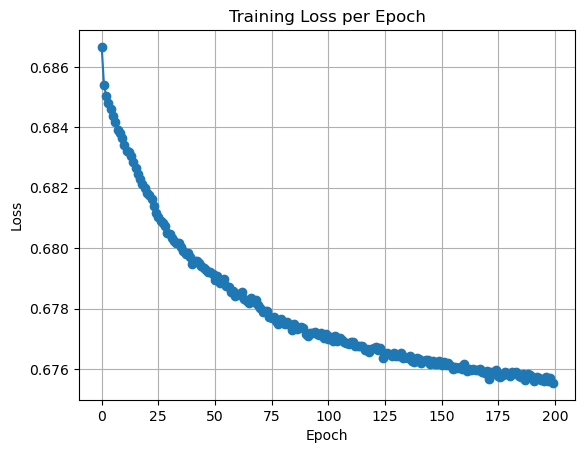

In [115]:
import matplotlib.pyplot as plt

plt.plot(loss_vals, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

In [120]:
torch.save(model.state_dict(), "miaNN")

In [126]:
real_adata2 = embed_adata("100_ind_1000_gene_subset2_ct0.h5ad", scvi_dir)
holdout_adata2 = embed_adata("group2_holdout.h5ad", scvi_dir)
synth_adata2 = embed_adata("1000_genes_100_ind_subset2_out.h5ad", scvi_dir)

train_dists2 = get_dist_to_synth_nn(real_adata2.obsm["X_scVI"], synth_adata2.obsm["X_scVI"])
holdout_dists2 = get_dist_to_synth_nn(holdout_adata2.obsm["X_scVI"], synth_adata2.obsm["X_scVI"])

test_dataset = get_tensor_dataset(real_adata2.obsm["X_scVI"], train_dists2, holdout_adata2.obsm["X_scVI"], holdout_dists2)

INFO     File 100_ind_1000_gene_subset1/model.pt already downloaded                                                


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pat

INFO     File 100_ind_1000_gene_subset1/model.pt already downloaded                                                


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pat

INFO     File 100_ind_1000_gene_subset1/model.pt already downloaded                                                


/home/patrick/miniconda3/envs/sctest-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pat

Train features shape torch.Size([45389, 11])
Train labels shape torch.Size([45389, 1])
Holdout features shape torch.Size([48957, 11])
Holdout labels shape torch.Size([48957, 1])
Features shape torch.Size([94346, 11])
Labels shape torch.Size([94346, 1])


In [127]:
from sklearn.metrics import classification_report
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.float(), batch_y.float()
        y_pred = model(batch_X)
        y_pred_label = (y_pred >= 0.5).float()
        all_preds.append(y_pred_label)
        all_labels.append(batch_y)

all_preds = torch.cat(all_preds).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.53      0.27      0.35     48957
         1.0       0.48      0.75      0.59     45389

    accuracy                           0.50     94346
   macro avg       0.51      0.51      0.47     94346
weighted avg       0.51      0.50      0.47     94346

